In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

sys.path.insert(0,'..')
%matplotlib inline

In [3]:
from dataset import Dataset
from models import CNP
from train import Trainer
from utils.dataset_utils import (load_data,train_test_split, make_features)

In [4]:
from types import SimpleNamespace

In [59]:
config = SimpleNamespace(**trainconfig)

In [60]:
df = pd.read_pickle('../data/btc_30m.pkl')

In [61]:
x,ts = train_test_split(df,test_mode=config.test_mode)

In [62]:
x, index, stats = make_features(x, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [67]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=True)

INFO:tensorflow:Dataset loaded. Total Batches: 36540


In [68]:
model = NP(dataset.shape, config)
trainer = Trainer(model, config, path=config.path)

INFO:tensorflow:Built model with scope np


In [69]:
trainer.init_sess()

In [70]:
losses = []
ep = 0
for t in tqdm(range(config.steps), desc='Train steps: '):
    try:
        batch,_ = dataset.next()
        loss = trainer.fit(batch, stats=dataset.stats)
        losses.append(loss)
    except StopIteration:
        ep+=1
        if ep % 50 == 0:
            tqdm.write('Ep: {}, Avg_loss: {}'.format(ep, np.mean(losses)), end='\n')
        dataset.reset()
        losses=[]

Train steps: 100%|██████████| 100000/100000 [07:19<00:00, 227.63it/s]


In [71]:
x, index, stats = make_features(ts, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [72]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=False, window=config.pred_len)

INFO:tensorflow:Dataset loaded. Total Batches: 2607


In [73]:
preds = {'d':[], 'h':[],'sigma':[], 'y':[]}
for batch, date in dataset:
    mu, sigma = trainer.sess.run([model.h, model.sigma], feed_dict=trainer._get_dict(batch))
    preds['d'].append(date)
    preds['h'].append(mu)
    preds['sigma'].append(sigma)
    preds['y'].append(batch['y'])

In [74]:
y = pd.Series(np.vstack(preds['y']).flatten(), name='y')
mu = pd.Series(np.vstack(preds['h']).flatten(), name='h')
sigma = pd.Series(np.vstack(preds['sigma']).flatten(), name='sigma')

In [75]:
y_hat = mu * dataset.stats['std'] + dataset.stats['mu']

In [76]:
df = pd.concat([y,y_hat, sigma],axis=1)

Text(0,0.5,'temperature')

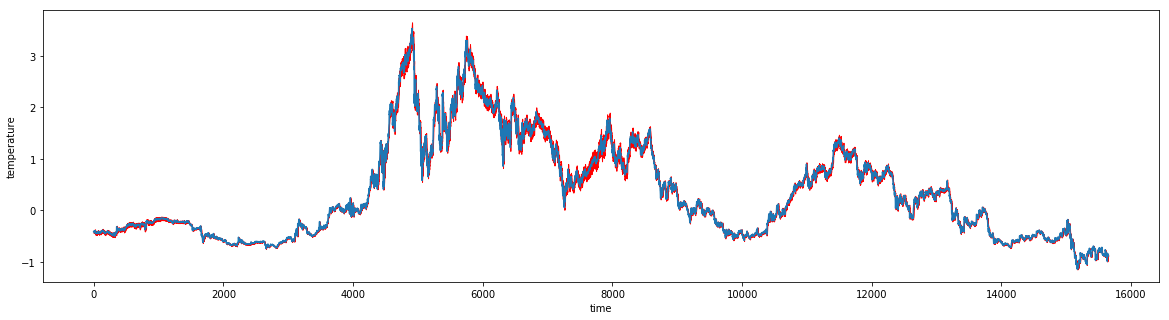

In [77]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(mu)
ax.fill_between(np.arange(0, y_hat.shape[0], 1),mu + 1.28*sigma, mu - 1.28*sigma,alpha=1,color='red')
ax.set_xlabel('time')
ax.set_ylabel('temperature')

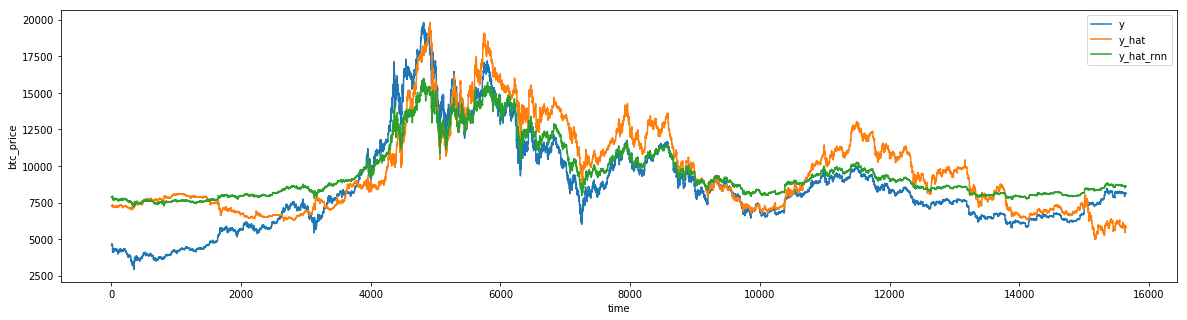

In [83]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df.y)
ax.plot(df.h)
ax.plot(rnn_df.h)
ax.set_xlabel('time')
ax.set_ylabel('btc_price')
ax.legend(['y','y_hat', 'y_hat_rnn'])

In [52]:
fig.savefig('np_sml.png')